In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
""" 
Horizontal data generation, wind and solar energy linear models implementation 
input: MeteorCOLUnited.csv
    WindSpeed.csv
    GHI_generation.csv
output: GHI_2021_preds.csv
    Wind_2021_preds.csv
    GHI_gen_preds.csv
    Wind_gen_preds.csv
"""

In [2]:

Drops=['Unnamed: 0','Unnamed: 24','Unnamed: 13','Global Horizontal UV Irradiance (280-400nm)','Global Horizontal UV Irradiance (295-385nm)','DHI','DNI','Clearsky DHI','Clearsky DNI','Fill Flag','File']
GroupedBy=['Latitude','Longitude','Year','Month','Day','Hour']
data_path='/home/bleon/Documents/DS4A/DS4A_Project/Processed_Data/'
data=pd.read_csv(data_path+'MeteorCOLUnited.csv').drop(columns=Drops).groupby(GroupedBy).mean().reset_index()

data["Location"]=list(zip(data['Latitude'],data['Longitude']))
data["Year1"]=data["Year"].astype("str")
locations=data["Location"].unique().tolist()
variables=["GHI","Wind Speed"]

data.head(10)

Latitude  Longitude  Year  Month  Day  Hour  Minute    GHI  Clearsky GHI  \
0      4.29     -74.82  2016      1    1     0    15.0    0.0           0.0   
1      4.29     -74.82  2016      1    1     1    15.0    0.0           0.0   
2      4.29     -74.82  2016      1    1     2    15.0    0.0           0.0   
3      4.29     -74.82  2016      1    1     3    15.0    0.0           0.0   
4      4.29     -74.82  2016      1    1     4    15.0    0.0           0.0   
5      4.29     -74.82  2016      1    1     5    15.0    0.0           0.0   
6      4.29     -74.82  2016      1    1     6    15.0   23.0          23.0   
7      4.29     -74.82  2016      1    1     7    15.0  205.0         205.0   
8      4.29     -74.82  2016      1    1     8    15.0  436.0         436.0   
9      4.29     -74.82  2016      1    1     9    15.0  645.5         645.5   

   Cloud Type  ...  Solar Zenith Angle  Surface Albedo  Wind Speed  \
0         0.0  ...             160.665           0.157        1.25   
1         1.0  ...             154.200           0.157        1.10   
2         0.5  ...             142.875           0.157        1.10   
3         0.5  ...             129.915           0.157        1.10   
4         0.5  ...             116.365           0.157        1.20   
5         0.5  ...             102.610           0.157        1.25   
6         0.5  ...              88.830           0.157        1.70   
7         0.0  ...              75.180           0.157        2.30   
8         0.0  ...              61.860           0.157        2.25   
9         0.0  ...              49.205           0.157        2.15   

   Precipitable Water  Wind Direction  Relative Humidity  Temperature  \
0              4.9305           272.9             83.705         27.0   
1              4.9030           272.7             85.780         26.5   
2              4.8880           271.8             87.355         26.0   
3              4.8875           268.6             86.390         25.5   
4              4.8995           265.0             88.400         25.0   
5              4.9345           264.6             90.750         25.0   
6              4.9955           264.6             84.010         26.5   
7              5.0685           251.7             70.080         29.5   
8              5.1395           231.3             61.790         31.5   
9              5.1960           220.4             54.290         33.5   

   Pressure        Location Year1  
0     975.0  (4.29, -74.82)  2016  
1     970.0  (4.29, -74.82)  2016  
2     970.0  (4.29, -74.82)  2016  
3     970.0  (4.29, -74.82)  2016  
4     970.0  (4.29, -74.82)  2016  
5     975.0  (4.29, -74.82)  2016  
6     980.0  (4.29, -74.82)  2016  
7     980.0  (4.29, -74.82)  2016  
8     980.0  (4.29, -74.82)  2016  
9     980.0  (4.29, -74.82)  2016  

[10 rows x 21 columns]

First we define he Horizontal function, where data is turned into a horizontal dataframe with years as columns for the input variable

In [3]:

def Horizontal(location,variable):
    GroupedBy=['Location','Month','Day','Hour']
    Horizontal_data=data[data["Location"]==location].reset_index().fillna(0).pivot_table(index=GroupedBy,columns='Year1',values=variable,aggfunc=np.max).reset_index()
    return Horizontal_data

0.0004494720662356851


(array([ 14., 104., 479., 514., 426., 141.,  49.,  18.,   6.,   1.]),
 array([-0.22290056, -0.16122018, -0.09953979, -0.0378594 ,  0.02382099,
         0.08550138,  0.14718176,  0.20886215,  0.27054254,  0.33222293,
         0.39390332]),
 <BarContainer object of 10 artists>)

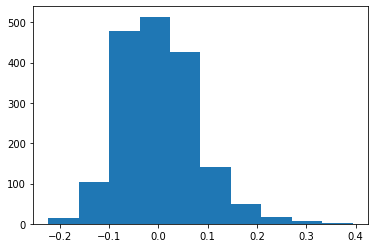

In [4]:
#Testing on one locaton
loc0_GHI=Horizontal(locations[5],"Wind Speed").dropna()

columns_Years=list(loc0_GHI.columns)[4:-1]
columns_Years
X=loc0_GHI[columns_Years]
Y=loc0_GHI['2020']
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.2)

linear_model=LinearRegression().fit(X_train,y_train)
testing_2020=linear_model.predict(X_test)
distance=y_test-testing_2020
print(distance.mean())
plt.hist(distance)

In [5]:
def Predictor_2021(location,variable):
    StrLoc=str(location)
    df=Horizontal(location,variable).dropna()
    cols=list(df.columns)[4:]
    X_train=df[cols[:-1]]
    Y_train=df[cols[-1]]
    X_predict=df[cols[1:]]
    
    linear_model=LinearRegression().fit(X_train,Y_train)
    pred_2021=linear_model.predict(X_predict)
    df['Resids_2020']=linear_model.predict(X_train)-Y_train
    df['2021 prediction '+variable]=pred_2021.round(2)
    df["datetime 2021"]=pd.to_datetime("2021-"+df["Month"].astype("str")+"-"+df["Day"].astype("str")+" "+df["Hour"].astype("str")+":00:00")
    return df

In [6]:
Loc6_GHI=Predictor_2021(locations[6],"GHI")

Loc6_GHI.head(10)

Year1       Location  Month  Day  Hour   1999   2000   2001   2002   2003  \
0      (8.37, -74.9)      1    1     0    0.0    0.0    0.0    0.0    0.0   
1      (8.37, -74.9)      1    1     1    0.0    0.0    0.0    0.0    0.0   
2      (8.37, -74.9)      1    1     2    0.0    0.0    0.0    0.0    0.0   
3      (8.37, -74.9)      1    1     3    0.0    0.0    0.0    0.0    0.0   
4      (8.37, -74.9)      1    1     4    0.0    0.0    0.0    0.0    0.0   
5      (8.37, -74.9)      1    1     5    0.0    0.0    0.0    0.0    0.0   
6      (8.37, -74.9)      1    1     6    4.5   14.0   13.0   11.0   12.0   
7      (8.37, -74.9)      1    1     7   97.5  181.5   88.5  166.0  167.0   
8      (8.37, -74.9)      1    1     8  217.5  414.0  268.5  175.5  395.0   
9      (8.37, -74.9)      1    1     9  346.0  624.0  612.0  360.0  604.5   

Year1   2004  ...   2014   2015   2016   2017   2018   2019   2020  \
0        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6       12.5  ...   12.5   12.5    1.0   13.0    7.0   14.0   11.0   
7      168.0  ...  172.0  173.5   17.0  174.5   70.5  177.0  105.5   
8      394.0  ...  296.5  407.0   54.0  297.0  252.0  406.5  336.0   
9      603.0  ...  615.5  621.0  239.5  510.0  417.0  616.5  430.0   

Year1  Resids_2020  2021 prediction GHI       datetime 2021  
0         1.517793                 1.52 2021-01-01 00:00:00  
1         1.517793                 1.52 2021-01-01 01:00:00  
2         1.517793                 1.52 2021-01-01 02:00:00  
3         1.517793                 1.52 2021-01-01 03:00:00  
4         1.517793                 1.52 2021-01-01 04:00:00  
5         1.517793                 1.52 2021-01-01 05:00:00  
6         1.575754                12.77 2021-01-01 06:00:00  
7        43.594391               139.60 2021-01-01 07:00:00  
8       -12.642828               327.72 2021-01-01 08:00:00  
9       104.101020               520.24 2021-01-01 09:00:00  

[10 rows x 29 columns]

In [7]:

#Ejemplo

# Loc6_GHI=Predictor_2021(locations[6],"Wind Speed")

Loc6_GHI.head(10)

Year1       Location  Month  Day  Hour   1999   2000   2001   2002   2003  \
0      (8.37, -74.9)      1    1     0    0.0    0.0    0.0    0.0    0.0   
1      (8.37, -74.9)      1    1     1    0.0    0.0    0.0    0.0    0.0   
2      (8.37, -74.9)      1    1     2    0.0    0.0    0.0    0.0    0.0   
3      (8.37, -74.9)      1    1     3    0.0    0.0    0.0    0.0    0.0   
4      (8.37, -74.9)      1    1     4    0.0    0.0    0.0    0.0    0.0   
5      (8.37, -74.9)      1    1     5    0.0    0.0    0.0    0.0    0.0   
6      (8.37, -74.9)      1    1     6    4.5   14.0   13.0   11.0   12.0   
7      (8.37, -74.9)      1    1     7   97.5  181.5   88.5  166.0  167.0   
8      (8.37, -74.9)      1    1     8  217.5  414.0  268.5  175.5  395.0   
9      (8.37, -74.9)      1    1     9  346.0  624.0  612.0  360.0  604.5   

Year1   2004  ...   2014   2015   2016   2017   2018   2019   2020  \
0        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6       12.5  ...   12.5   12.5    1.0   13.0    7.0   14.0   11.0   
7      168.0  ...  172.0  173.5   17.0  174.5   70.5  177.0  105.5   
8      394.0  ...  296.5  407.0   54.0  297.0  252.0  406.5  336.0   
9      603.0  ...  615.5  621.0  239.5  510.0  417.0  616.5  430.0   

Year1  Resids_2020  2021 prediction GHI       datetime 2021  
0         1.517793                 1.52 2021-01-01 00:00:00  
1         1.517793                 1.52 2021-01-01 01:00:00  
2         1.517793                 1.52 2021-01-01 02:00:00  
3         1.517793                 1.52 2021-01-01 03:00:00  
4         1.517793                 1.52 2021-01-01 04:00:00  
5         1.517793                 1.52 2021-01-01 05:00:00  
6         1.575754                12.77 2021-01-01 06:00:00  
7        43.594391               139.60 2021-01-01 07:00:00  
8       -12.642828               327.72 2021-01-01 08:00:00  
9       104.101020               520.24 2021-01-01 09:00:00  

[10 rows x 29 columns]

Example of prediction for 2021 for 1 location (location 6)

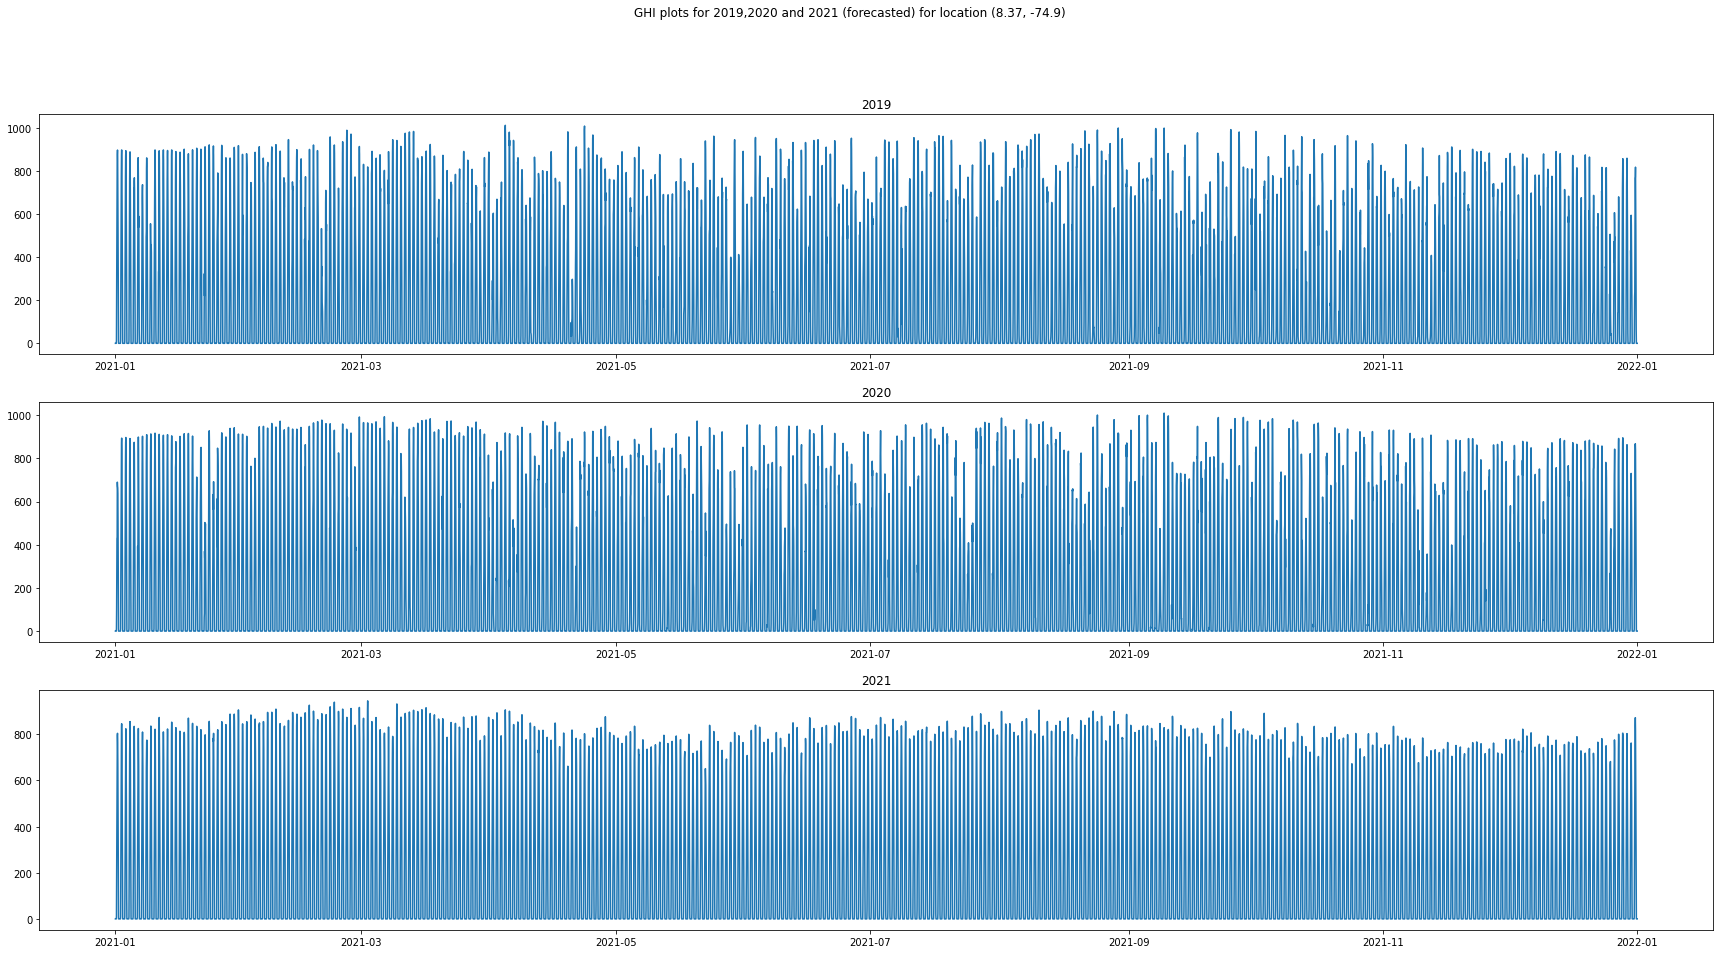

In [8]:
fig,(axes)=plt.subplots(3,1,figsize=(30,15))
axes[0].plot(Loc6_GHI["datetime 2021"],Loc6_GHI["2019"])
axes[0].set_title('2019')
axes[1].plot(Loc6_GHI["datetime 2021"],Loc6_GHI["2020"])
axes[1].set_title('2020')
axes[2].plot(Loc6_GHI["datetime 2021"],Loc6_GHI["2021 prediction GHI"])
axes[2].set_title('2021')
plt.suptitle("GHI plots for 2019,2020 and 2021 (forecasted) for location {}".format(locations[6]))
plt.show()


In [9]:
GHI_preds=pd.DataFrame()
i=0
for loc in locations:
   if not i:
      GHI_preds["datetime"]=Predictor_2021(loc,"GHI")["datetime 2021"]
      i+=1
   GHI_preds[str(loc)+" 2021 GHI"]=Predictor_2021(loc,"GHI")['2021 prediction GHI']

In [10]:
GHI_preds.describe()

(4.29, -74.82) 2021 GHI  (6.73, -76.7) 2021 GHI  \
count              8760.000000             8760.000000   
mean                151.749831              183.442845   
std                 168.243508              235.662044   
min                  21.890000                3.520000   
25%                  21.890000                3.520000   
50%                  34.040000               11.750000   
75%                 292.707500              389.202500   
max                 604.740000              845.480000   

       (7.33, -75.78) 2021 GHI  (7.85, -76.82) 2021 GHI  \
count              8760.000000              8760.000000   
mean                176.745188               213.993063   
std                 225.997019               276.700827   
min                  -0.510000                 1.410000   
25%                  -0.510000                 1.410000   
50%                  10.370000                10.690000   
75%                 371.387500               458.400000   
max                 848.810000               896.340000   

       (8.05, -75.18) 2021 GHI  (8.21, -76.38) 2021 GHI  \
count              8760.000000              8736.000000   
mean                227.518969               200.908954   
std                 289.775526               252.502663   
min                   1.650000                 3.220000   
25%                   1.650000                 3.240000   
50%                  11.500000                12.065000   
75%                 503.012500               438.752500   
max                 890.720000               845.820000   

       (8.37, -74.9) 2021 GHI  (8.53, -76.7) 2021 GHI  \
count             8760.000000             8760.000000   
mean               234.637869              210.643113   
std                301.465921              265.088443   
min                  1.520000                3.350000   
25%                  1.520000                3.350000   
50%                 11.015000               12.805000   
75%                510.497500              453.395000   
max                943.840000              865.520000   

       (8.77, -75.86) 2021 GHI  (8.93, -75.46) 2021 GHI  ...  \
count              8760.000000              8760.000000  ...   
mean                217.886884               225.373773  ...   
std                 277.149561               288.644522  ...   
min                   1.340000                 0.490000  ...   
25%                   1.340000                 0.490000  ...   
50%                  10.370000                11.040000  ...   
75%                 487.092500               501.005000  ...   
max                 882.040000               914.930000  ...   

       (9.73, -75.06) 2021 GHI  (9.73, -73.86) 2021 GHI  \
count              8760.000000              8760.000000   
mean                226.728930               248.260741   
std                 292.731592               317.926193   
min                  -0.410000                 0.490000   
25%                  -0.410000                 0.490000   
50%                   9.535000                10.465000   
75%                 494.835000               546.932500   
max                 925.710000               961.440000   

       (10.21, -74.9) 2021 GHI  (10.41, -75.58) 2021 GHI  \
count              8760.000000               8760.000000   
mean                237.901389                239.780672   
std                 307.849676                292.742825   
min                   1.330000                 14.020000   
25%                   1.330000                 14.020000   
50%                   9.875000                 26.520000   
75%                 519.290000                487.895000   
max                 965.220000                958.660000   

       (10.45, -73.18) 2021 GHI  (10.49, -74.34) 2021 GHI  \
count               8760.000000               8760.000000   
mean                 249.017647                240.014450   
std                  323.902258                310.403972   
min         

In [11]:
Wind_preds=pd.DataFrame()
i=0
for loc in locations:
   if not i:
      Wind_preds["datetime"]=Predictor_2021(loc,"Wind Speed")["datetime 2021"]
      i+=1
   Wind_preds[str(loc)+" 2021 Wind Speed"]=Predictor_2021(loc,"Wind Speed")['2021 prediction Wind Speed']

In [12]:
Wind_preds.describe()

(4.29, -74.82) 2021 Wind Speed  (6.73, -76.7) 2021 Wind Speed  \
count                     8760.000000                    8760.000000   
mean                         0.322323                       0.474153   
std                          0.028319                       0.213840   
min                          0.210000                       0.180000   
25%                          0.310000                       0.300000   
50%                          0.330000                       0.380000   
75%                          0.340000                       0.660000   
max                          0.370000                       1.060000   

       (7.33, -75.78) 2021 Wind Speed  (7.85, -76.82) 2021 Wind Speed  \
count                     8760.000000                     8760.000000   
mean                         0.360680                        0.767547   
std                          0.092657                        0.242830   
min                          0.160000                        0.340000   
25%                          0.300000                        0.590000   
50%                          0.340000                        0.690000   
75%                          0.400000                        0.870000   
max                          0.730000                        1.730000   

       (8.05, -75.18) 2021 Wind Speed  (8.21, -76.38) 2021 Wind Speed  \
count                     8760.000000                     8736.000000   
mean                         0.135688                        0.238662   
std                          0.057093                        0.065077   
min                          0.030000                        0.080000   
25%                          0.090000                        0.190000   
50%                          0.130000                        0.250000   
75%                          0.180000                        0.280000   
max                          0.380000                        0.510000   

       (8.37, -74.9) 2021 Wind Speed  (8.53, -76.7) 2021 Wind Speed  \
count                    8760.000000                    8760.000000   
mean                        0.148935                       1.564023   
std                         0.061018                       0.450406   
min                         0.040000                       0.500000   
25%                         0.100000                       1.230000   
50%                         0.140000                       1.520000   
75%                         0.190000                       1.900000   
max                         0.380000                       2.730000   

       (8.77, -75.86) 2021 Wind Speed  (8.93, -75.46) 2021 Wind Speed  ...  \
count                     8760.000000                     8760.000000  ...   
mean                         0.410301                        0.303308  ...   
std                          0.190188                        0.184824  ...   
min                          0.120000                        0.030000  ...   
25%                          0.290000                        0.190000  ...   
50%                          0.370000                        0.260000  ...   
75%                          0.470000                        0.350000  ...   
max                          1.370000                        1.270000  ...   

       (9.73, -75.06) 2021 Wind Speed  (9.73, -73.86) 2021 Wind Speed  \
count                     8760.000000                     8760.000000   
mean                         0.348313                        0.081998   
std                          0.173371                        0.034913   
min                          0.110000                        0.000000   
25%                          0.230000                        0.060000   
50%                          0.300000                        0.090000   
75%                          0.410000                        0.110000   
max                          1.250000                        0.180000   

       (10.21, -74.9) 2021 Wind Speed  (1

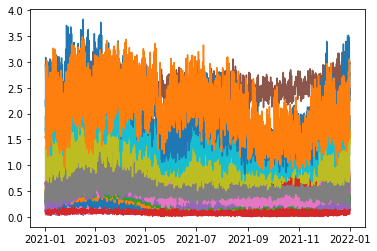

In [13]:
for cols in Wind_preds.drop(columns="datetime").columns:
    plt.plot(Wind_preds["datetime"],Wind_preds[cols])
    

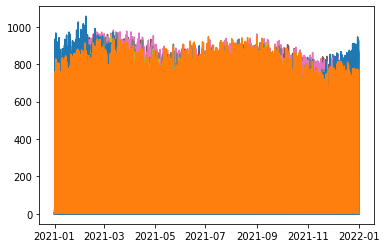

In [14]:
for cols in GHI_preds.drop(columns="datetime").columns:
    plt.plot(GHI_preds["datetime"],GHI_preds[cols])

In [15]:
GHI_preds.to_csv(data_path+"GHI_2021_preds.csv")
Wind_preds.to_csv(data_path+"Wind_2021_preds.csv")

    WindSpeed    MAX
0         4.0   1265
1         4.5   1801
2         5.0   2471
3         5.5   3289
4         6.0   4270
5         6.5   5429
6         7.0   6781
7         7.5   8340
8         8.0  10120
9         8.5  12140
10        9.0  14410
     GHI     MAX    MEAN    STD
0    200   20.25  -6.114  49.21
1    300   31.67   2.007  48.02
2    400   43.42  10.120  47.21
3    500   55.41  18.220  46.82
4    600   67.57  26.310  46.84
5    700   79.87  34.390  47.28
6    800   92.28  42.460  48.11
7    900  104.80  50.520  49.33
8   1000  117.30  58.570  50.89
9   1100  129.90  66.610  52.76
10  1200  142.60  74.640  45.91


Text(0, 0.5, 'Generación máxima')

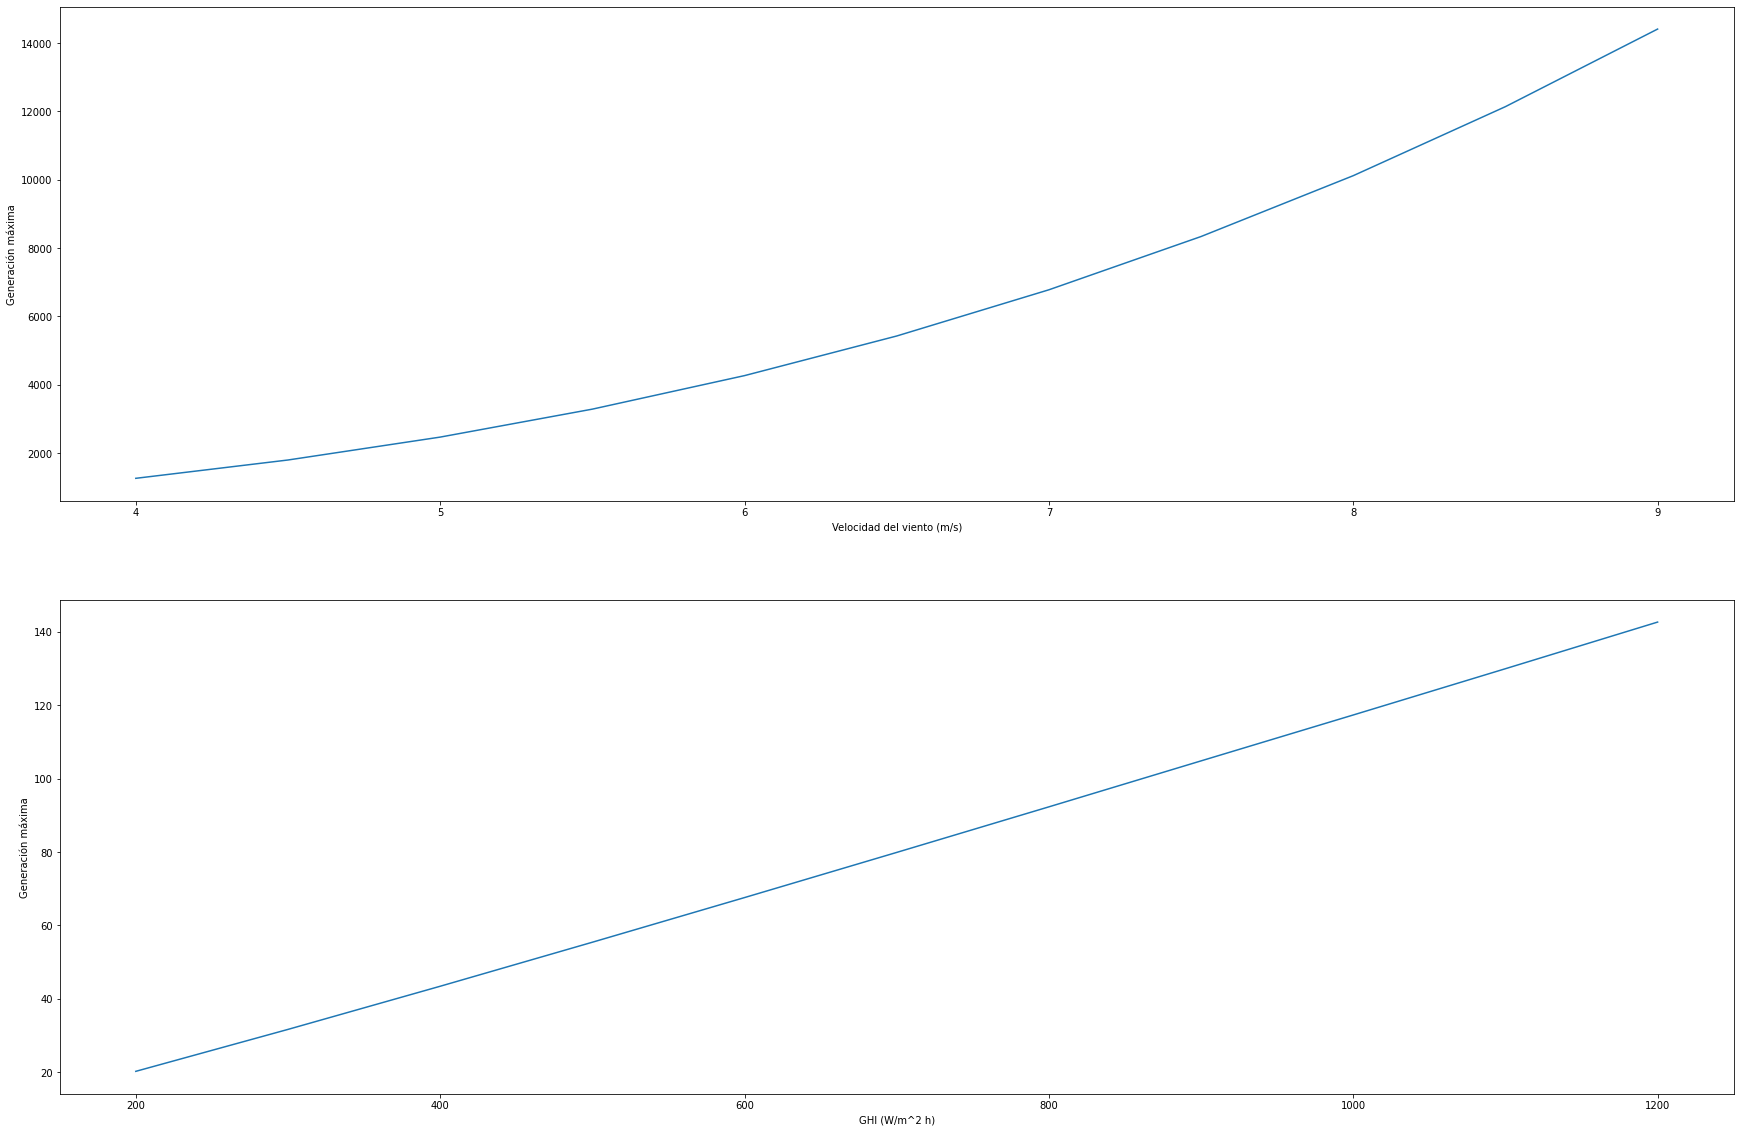

In [16]:
Wind_gen=pd.read_csv(data_path+'WindSpeed.csv')
GHI_gen=pd.read_csv(data_path+'GHI_generation.csv')
print(Wind_gen)
print(GHI_gen)
fig,axes=plt.subplots(2,1, figsize=(30,20))
axes[0].plot(Wind_gen["WindSpeed"],Wind_gen["MAX"])
axes[0].set_xlabel("Velocidad del viento (m/s)")
axes[0].set_ylabel("Generación máxima")
axes[1].plot(GHI_gen["GHI"],GHI_gen["MAX"])
axes[1].set_xlabel(r"GHI (W/m^2 h)")
axes[1].set_ylabel("Generación máxima")
# plt.show()

Vemos que hay una clara relación lineal entre la generación máxima solar y GHI mientras que para generación eolica se observa una curvatura al parecer cuadrática.

In [17]:
Xg,yg=GHI_gen[["GHI"]],GHI_gen["MAX"]
model_GHI=LinearRegression().fit(Xg,yg)

Wind_gen["WindSquared"]=Wind_gen["WindSpeed"].apply(lambda x:x**2)
Xw,yw=Wind_gen[["WindSquared","WindSpeed"]],Wind_gen["MAX"]
model_Wind=LinearRegression().fit(Xw,yw)

    

In [18]:
IntGHI,COEFGHI=model_GHI.intercept_ , model_GHI.coef_[0]
IntWind,COEFWIND,COEFWIND2=model_Wind.intercept_ , model_Wind.coef_[0], model_Wind.coef_[1]
def Wind_real_generation(x):
    return IntWind+COEFWIND*x+COEFWIND2*(x**2)
def Solar_real_generation(x):
    return IntWind+COEFGHI*x
# def GHI_Model_apply(x):

In [19]:
#Wind_preds GHI_preds
Wind_gen_preds=pd.DataFrame()
for column in Wind_preds.drop(columns="datetime").columns:
    Wind_gen_preds[column]=Wind_preds[column].apply(Wind_real_generation)
Wind_gen_preds[Wind_gen_preds<0]=0
Wind_gen_preds["datetime"]=Wind_preds["datetime"]

GHI_gen_preds=pd.DataFrame()
for column in GHI_preds.drop(columns="datetime").columns:
    GHI_gen_preds[column]=GHI_preds[column].apply(Solar_real_generation)
GHI_gen_preds[GHI_gen_preds<0]=0
GHI_gen_preds["datetime"]=GHI_preds["datetime"]


In [20]:
# Wind_gen_preds[Wind_gen_preds<0]=0
Wind_gen_preds.to_csv(data_path+"Wind_gen_preds.csv")
# GHI_gen_preds[GHI_gen_preds<0]=0
GHI_gen_preds.to_csv(data_path+"GHI_gen_preds.csv")

<AxesSubplot:>

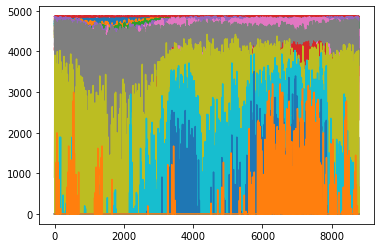

In [21]:
Wind_gen_preds.drop(columns=["datetime"]).plot(legend=False)